In [1]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_ = pd.read_csv('/kaggle/input/150k-lyrics-labeled-with-spotify-valence/labeled_lyrics_cleaned.csv')

In [4]:
df = df_.copy()

In [5]:
df.head()

,Unnamed: 0,artist,seq,song,label
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371


In [6]:
df.loc[df["label"]<0.5,"label"] = 0
df.loc[df["label"]>=0.5,"label"] = 1


In [7]:
df.isnull().sum()

Unnamed: 0    0
artist        0
seq           0
song          0
label         0
dtype: int64

In [8]:
# word_count
df['word_count'] = df['seq'].apply(lambda x: len(str(x).split()))
df.sort_values(by='word_count', ascending=False)

,Unnamed: 0,artist,seq,song,label,word_count
146351,146351,Kanye West,"Yo fuck you, Kanye, first and foremost\r\nFor ...",Last Call,1.0,2843
54722,54722,Bal-Sagoth,[5:58]\r\n\r\nEpisode: IX \r\n\r\nFrom Sage Da...,The Obsidian Crown Unbound,0.0,2476
89877,89877,Arlo Guthrie,You can get anything you want at Alice's resta...,Alice's Restaurant Massacree,1.0,2437
7087,7087,H.S.E.,Will you please take your seats\r\nAnd clear t...,Freestyle Session,1.0,1857
65836,65836,Beastie Boys,There's a girl over there\nWith long brown hai...,B-Boy Bouillabaisse,0.0,1792
...,...,...,...,...,...,...
120623,120623,Toto,(instrumental)\n,Child's Anthem,0.0,1
142585,142585,Deep Blue Something,[Instrumental]\n,Gammer Gerten's Needle,0.0,1
79650,79650,Gob,Instrument\n\n\n\n,Marching Song,1.0,1
105185,105185,Squirrel Nut Zippers,(Instrumental)\n\n\n\n,Memphis Exorcism,1.0,1


In [9]:
df.loc[df["word_count"] <20]

,Unnamed: 0,artist,seq,song,label,word_count
229,229,Ella Fitzgerald,"Come on, wail\r\nWail, cotton tail\r\nBenny We...",Cotton Tail,1.0,17
246,246,Ella Fitzgerald,There's a song that's really jumping\r\nAnd th...,Squatty Roo,1.0,18
1189,1189,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Mother Tongue,0.0,18
1190,1190,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Orbis de Ignis,0.0,18
1208,1208,Dead Can Dance,From the body to the soul\r\nWhere our hearts ...,Oman,1.0,17
...,...,...,...,...,...,...
157206,157206,Behemoth,[Lyrics not available]\n\n\n\n\n\n,Malice,0.0,3
157209,157209,Behemoth,(Music by Nergal)\n\nInstrumental\n\n\n\n,Intro,0.0,4
157249,157249,Beirut,What can you do\r\nWhen the curtain falls\r\n\...,After the Curtain,0.0,19
157253,157253,Beirut,"They call it night,\r\nThey call it night\r\nA...",The Gulag Orkestar,0.0,13


In [10]:
df["word_count"].mean()

219.57868812084394

In [11]:
df.loc[df["seq"] == "[Instrumental]"]

,Unnamed: 0,artist,seq,song,label,word_count
1923,1923,Pete Rock,[Instrumental],Intro,1.0,1
22267,22267,Katatonia,[Instrumental],Elohim Meth,0.0,1
25033,25033,Peter Gabriel,[Instrumental],Cloudless,0.0,1
54715,54715,Bal-Sagoth,[Instrumental],Six Keys to the Onyx Pyramid,0.0,1
57653,57653,Anathema,[Instrumental],2000 & Gone,0.0,1
59642,59642,Meat Puppets,[Instrumental],Aurora Borealis,1.0,1
96063,96063,David Gilmour,[Instrumental],Castellorizon,0.0,1
101082,101082,Gipsy Kings,[Instrumental],Intro,0.0,1
119433,119433,Disharmonic Orchestra,[Instrumental],Dual Peepholes,1.0,1
125826,125826,Infected Mushroom,[Instrumental],Bombat,0.0,1


In [12]:
df.loc[df["word_count"] <= 18]

,Unnamed: 0,artist,seq,song,label,word_count
229,229,Ella Fitzgerald,"Come on, wail\r\nWail, cotton tail\r\nBenny We...",Cotton Tail,1.0,17
246,246,Ella Fitzgerald,There's a song that's really jumping\r\nAnd th...,Squatty Roo,1.0,18
1189,1189,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Mother Tongue,0.0,18
1190,1190,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Orbis de Ignis,0.0,18
1208,1208,Dead Can Dance,From the body to the soul\r\nWhere our hearts ...,Oman,1.0,17
...,...,...,...,...,...,...
157171,157171,Beenie Man,"Pussy language\r\nShout it out\r\nBad man, nuh...",Pu**y Language,1.0,11
157206,157206,Behemoth,[Lyrics not available]\n\n\n\n\n\n,Malice,0.0,3
157209,157209,Behemoth,(Music by Nergal)\n\nInstrumental\n\n\n\n,Intro,0.0,4
157253,157253,Beirut,"They call it night,\r\nThey call it night\r\nA...",The Gulag Orkestar,0.0,13


In [13]:
df.loc[df["word_count"] == 3]

,Unnamed: 0,artist,seq,song,label,word_count
4801,4801,DJ Full Visionary,In the Night. \r\n,In the Night,1.0,3
9243,9243,Johnnie Allan,Lyrics @ http://www.morganblanchard.com/Swamp...,Your Picture,1.0,3
10326,10326,Anggun,....Dewi...malam....(Night\r\nAngel's song),Gita,1.0,3
13916,13916,This Mortal Coil,[_________________________]\n[________________...,Loose Joints,0.0,3
14306,14306,Link 80,[Dedicated to the,Unbroken,0.0,3
17238,17238,Donald Byrd,Design a nation!,Design a Nation,1.0,3
20646,20646,Todd Rundgren,"Oh, ah, oh",There Are No Words,0.0,3
24300,24300,The Moody Blues,Desolation...\r\nCreation...\r\nCommunication...,Procession,0.0,3
24569,24569,The Muffs,\n\nOoh ooh ooh,Slow,1.0,3
37863,37863,The Coup,Get it together,Outro,0.0,3


In [14]:
# https://www.youtube.com/watch?v=cxN9IZ005WU&ab_channel=OtterNeedles  
# df[49189]

In [15]:
df = df.loc[~df["word_count"] <= 3]

Now we cleaned instrumental songs and songs with very few lyrics, mostly contain music without any lyric during the song. 

We also need to clean lyrics contain *"'We haven\'t lyrics of this song. Please, add these lyrics for other users. Use "Correct". Thanks to you.\n\n\n\n'"* because even if seems like there's some lyric in the song from the word_count column, it actually does not and we must drop them too.

In [16]:
df.iloc[1189]["seq"]

'We haven\'t lyrics of this song. Please, add these lyrics for other users. Use "Correct". Thanks to you.\n\n\n\n'

In [17]:
df[df['seq'].str.contains("We haven't lyrics")==True]

,Unnamed: 0,artist,seq,song,label,word_count
1189,1189,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Mother Tongue,0.0,18
1190,1190,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Orbis de Ignis,0.0,18
28558,28558,Days of the New,"We haven't lyrics of this song. Please, add th...",Longfellow,1.0,18
28563,28563,Days of the New,"We haven't lyrics of this song. Please, add th...",Skeleton Key,0.0,18
28836,28836,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Chant of the Paladin,0.0,18
28837,28837,Dead Can Dance,"We haven't lyrics of this song. Please, add th...",Echolalia,0.0,18
148046,148046,Blackstreet,"We haven't lyrics of this song. Please, add\tt...",Baby Be Mine,0.0,18


In [18]:
df = df[~df['seq'].str.contains("We haven't lyrics")==True]

In [19]:
print(f'Number of unique values in artist = {df["artist"].nunique()}')
print(f'Number of unique values in song = {df["song"].nunique()} ')

Number of unique values in artist = 14691
Number of unique values in song = 99027 


In [20]:
df['seq'].duplicated().sum()

22357

In [21]:
df= df[~df['seq'].duplicated()]

# Prepare Your Data for NLP 

**HOW TO CLEAN YOUR DATA FOR NLP**

1. Remove Contractions

2. Tokenize

3. Remove punctuations

4. Remove stopwords

4. Stem

5. Lemmatize

 **1. Remove Contractions**

In [22]:
df['seq_no_contract'] = df['seq'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,..."
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,..."
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor..."
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light..."
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a..."


In [23]:
df['description_str'] = [' '.join(map(str, l)) for l in df['seq_no_contract']]
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu..."
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m..."
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ..."
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br..."


**2. Tokenization**

Now that we have removed any non-English lyrics let’s apply our tokenizer in order to split each individual word into a token. We will apply NLTK.word_tokenize() function to the “rating_description_str” column and create a new column named “tokenized”.

In [24]:
import re
def tokenize(text):
    tokens = re.split('\W+',text)
    return tokens
df['body_text_tokenized'] = df['description_str'].apply(lambda x: tokenize(x.lower()))
# convert to lower as Python is case sensitive

In [25]:
#df.iloc[11]

Unnamed: 0                                                                                                              11
artist                                                                                                                Elis
seq                    Nebel zieh'n gespentisch vor \r\nDer Sucher setzt leis seinen Fuss \r\nEinsam unterm Sternenzelt...
song                                                                                                       Engel der Nacht
label                                                                                                                  0.0
word_count                                                                                                             105
seq_no_contract        [Nebel, zieh'n, gespentisch, vor, Der, Sucher, setzt, leis, seinen, Fuss, Einsam, unterm, Sterne...
description_str        Nebel zieh'n gespentisch vor Der Sucher setzt leis seinen Fuss Einsam unterm Sternenzelt Rastlos...
body_text_tokeni

**3. Removing Punctuations**

Punctuation is often removed from our corpus since they serve little value once we begin to analyze our data. Continuing the previous pattern, we will create a new column which has the punctuation removed. We will again utilize a for-loop within a lambda function to iterate over the tokens but this time using an IF condition to only output alpha characters. It might be a little difficult to see but the tokenized “period” in the “ lower” column has been removed.

In [25]:
punc = string.punctuation
df['no_punc'] = df['body_text_tokenized'].apply(lambda x: [word for word in x if word not in punc])
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str,body_text_tokenized,no_punc
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu...","[no, no, i, are, not, ever, trapped, out, the,...","[no, no, i, are, not, ever, trapped, out, the,..."
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m...","[the, drinks, go, down, and, smoke, goes, up, ...","[the, drinks, go, down, and, smoke, goes, up, ..."
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...,"[she, do, not, live, on, planet, earth, no, mo...","[she, do, not, live, on, planet, earth, no, mo..."
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, off, that, grigio, mobbin, lights, l..."
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br...","[i, see, a, midnight, panther, so, gallant, an...","[i, see, a, midnight, panther, so, gallant, an..."


**4. Removing Stopwords**

Stopwords are typically useless words and do not add much meaning to a sentence. In the English language common stopwords include “you, he, she, in, a, has, are, etc.”. First, we need to import the NLTK stopwords library and set our stopwords to “english”. We are going to add a new column “no_stopwords” which will remove the stopwords from the “no_punc” column since it has been tokenized, had been converted to lowercase and punctuation was removed. Once again a for-loop within a lambda function will iterate over the tokens in “no_punc” and only return the tokens which do not exist in our “stop_words” variable.

In [26]:

stop_words =nltk.corpus.stopwords.words('english')
df['stopwords_removed'] = df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str,body_text_tokenized,no_punc,stopwords_removed
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu...","[no, no, i, are, not, ever, trapped, out, the,...","[no, no, i, are, not, ever, trapped, out, the,...","[ever, trapped, bando, oh, lord, get, wrong, k..."
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m...","[the, drinks, go, down, and, smoke, goes, up, ...","[the, drinks, go, down, and, smoke, goes, up, ...","[drinks, go, smoke, goes, feel, got, let, go, ..."
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...,"[she, do, not, live, on, planet, earth, no, mo...","[she, do, not, live, on, planet, earth, no, mo...","[live, planet, earth, found, love, venus, word..."
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, grigio, mobbin, lights, low, trippin..."
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br...","[i, see, a, midnight, panther, so, gallant, an...","[i, see, a, midnight, panther, so, gallant, an...","[see, midnight, panther, gallant, brave, found..."


**5. Stemming vs Lemmatization**

The idea of stemming is to reduce different forms of word usage into its root word. For example, “drive”, “drove”, “driving”, “driven”, “driver” are derivatives of the word “drive” and very often researchers want to remove this variability from their corpus. Compared to lemmatization, stemming is certainly the less complicated method but it often does not produce a dictionary-specific morphological root of the word. In other words, stemming the word “pies” will often produce a root of “pi” whereas lemmatization will find the morphological root of “pie”.

Instead of taking the easy way out with stemming, let’s apply lemmatization to our data.




In [27]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [28]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text
df['body_text_lemmatized'] = df['stopwords_removed'].apply(lambda x: lemmatizing(x))
df.head()


,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str,body_text_tokenized,no_punc,stopwords_removed,body_text_lemmatized
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu...","[no, no, i, are, not, ever, trapped, out, the,...","[no, no, i, are, not, ever, trapped, out, the,...","[ever, trapped, bando, oh, lord, get, wrong, k...","[ever, trapped, bando, oh, lord, get, wrong, k..."
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m...","[the, drinks, go, down, and, smoke, goes, up, ...","[the, drinks, go, down, and, smoke, goes, up, ...","[drinks, go, smoke, goes, feel, got, let, go, ...","[drink, go, smoke, go, feel, got, let, go, car..."
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...,"[she, do, not, live, on, planet, earth, no, mo...","[she, do, not, live, on, planet, earth, no, mo...","[live, planet, earth, found, love, venus, word...","[live, planet, earth, found, love, venus, word..."
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, grigio, mobbin, lights, low, trippin...","[trippin, grigio, mobbin, light, low, trippin,..."
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br...","[i, see, a, midnight, panther, so, gallant, an...","[i, see, a, midnight, panther, so, gallant, an...","[see, midnight, panther, gallant, brave, found...","[see, midnight, panther, gallant, brave, found..."


# Vectorize Data
Vectorizing is the process of encoding text as integers to create feature vectors so that machine learning algorithms can understand language.


**METHODS OF VECTORIZING DATA FOR NLP**

**1. Bag-of-Words**

**2. N-Grams**

**3. TF-IDF**


**1. BAG-OF-WORDS**

Bag-of-Words (BoW) or CountVectorizer describes the presence of words within the text data. This process gives a result of one if present in the sentence and zero if absent. This model therefore, creates a bag of words with a document-matrix count in each text document.

**2. N-GRAMS**

N-grams are simply all combinations of adjacent words or letters of length n that we find in our source text. N-grams with n=1 are called unigrams, n=2 are bigrams, and so on. 

**3. TF-IDF**

TF-IDF computes the relative frequency with which a word appears in a document compared to its frequency across all documents. It’s more useful than term frequency for identifying key words in each document (high frequency in that document, low frequency in other documents).

In [29]:
df['word_count_applied'] = df['body_text_lemmatized'].apply(lambda x: len(str(x).split()))
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str,body_text_tokenized,no_punc,stopwords_removed,body_text_lemmatized,word_count_applied
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu...","[no, no, i, are, not, ever, trapped, out, the,...","[no, no, i, are, not, ever, trapped, out, the,...","[ever, trapped, bando, oh, lord, get, wrong, k...","[ever, trapped, bando, oh, lord, get, wrong, k...",179
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m...","[the, drinks, go, down, and, smoke, goes, up, ...","[the, drinks, go, down, and, smoke, goes, up, ...","[drinks, go, smoke, goes, feel, got, let, go, ...","[drink, go, smoke, go, feel, got, let, go, car...",261
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...,"[she, do, not, live, on, planet, earth, no, mo...","[she, do, not, live, on, planet, earth, no, mo...","[live, planet, earth, found, love, venus, word...","[live, planet, earth, found, love, venus, word...",117
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, grigio, mobbin, lights, low, trippin...","[trippin, grigio, mobbin, light, low, trippin,...",179
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br...","[i, see, a, midnight, panther, so, gallant, an...","[i, see, a, midnight, panther, so, gallant, an...","[see, midnight, panther, gallant, brave, found...","[see, midnight, panther, gallant, brave, found...",78


**SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST**

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["body_text_lemmatized"],
                                                    df["label"],test_size=0.2,shuffle=True)

In [32]:
X_train.shape

(108791,)

In [33]:
X_train.head()

93772    [get, get, away, get, away, get, get, away, ge...
13751    [see, hand, reaching, help, understand, way, s...
87368    [sitting, fancy, table, ritzy, restaurant, sta...
37013    [made, mountain, made, tree, made, river, flow...
60399    [wonder, southbound, train, run, wonder, south...
Name: body_text_lemmatized, dtype: object

**Word2Vec**

In [37]:
from nltk.corpus import stopwords

In [38]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer() 

In [39]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

**Vectorize text**

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text,max_features=5000)
X_train = tfidf_vect.fit_transform(X_train)
X_test =  tfidf_vect.fit_transform(X_test)
#print(X_train.shape)
#print(X_train.get_feature_names_out())

**Final evaluation of models**

In [42]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  50.26104860651518


In [46]:
# fit the training dataset on the Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
logistic.fit(X_train,y_train)  
# predict the labels on validation dataset
#Predict y value for test dataset
predictions_Logistic = logistic.predict(X_test)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_Logistic, y_test)*100)

Naive Bayes Accuracy Score ->  50.46326935804103


In [47]:
################################################
#  XGBoost, CatBoost
################################################

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [50]:
# fit the training dataset on the XGB
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()
cv_results = cross_validate(xgboost_model, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.5092792604050385

In [55]:
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str,body_text_tokenized,no_punc,stopwords_removed,body_text_lemmatized,word_count_applied
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu...","[no, no, i, are, not, ever, trapped, out, the,...","[no, no, i, are, not, ever, trapped, out, the,...","[ever, trapped, bando, oh, lord, get, wrong, k...","[ever, trapped, bando, oh, lord, get, wrong, k...",179
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m...","[the, drinks, go, down, and, smoke, goes, up, ...","[the, drinks, go, down, and, smoke, goes, up, ...","[drinks, go, smoke, goes, feel, got, let, go, ...","[drink, go, smoke, go, feel, got, let, go, car...",261
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...,"[she, do, not, live, on, planet, earth, no, mo...","[she, do, not, live, on, planet, earth, no, mo...","[live, planet, earth, found, love, venus, word...","[live, planet, earth, found, love, venus, word...",117
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, grigio, mobbin, lights, low, trippin...","[trippin, grigio, mobbin, light, low, trippin,...",179
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br...","[i, see, a, midnight, panther, so, gallant, an...","[i, see, a, midnight, panther, so, gallant, an...","[see, midnight, panther, gallant, brave, found...","[see, midnight, panther, gallant, brave, found...",78


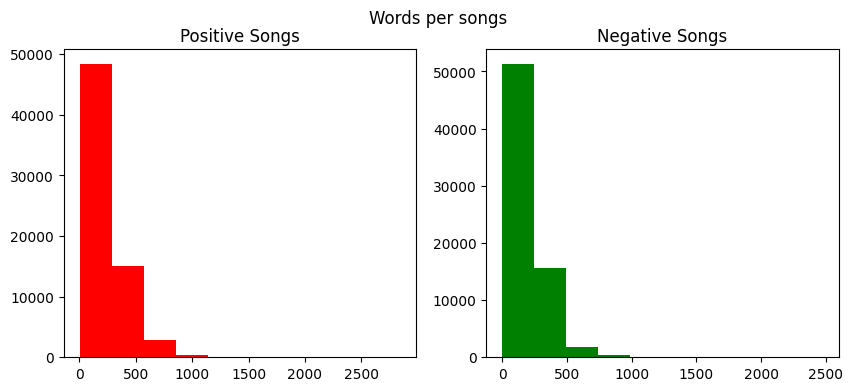

In [56]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df['label']==1.0]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Positive Songs')
train_words=df[df['label']==0.0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Negative Songs')
fig.suptitle('Words per songs')
plt.show()

In [73]:
from nltk import ngrams
import numpy as np
import matplotlib.pyplot as plt
import unicodedata

In [85]:
df['words'] = df['body_text_lemmatized'].apply(lambda x: ','.join(set(x)))

In [90]:
df['words'].head()

0    shit,everybody,got,loving,dream,heard,shout,pl...
1    eye,gone,like,circle,song,let,care,happier,hop...
2    gone,man,caught,like,space,cheating,found,faul...
3    telling,suck,going,number,got,hell,picked,chea...
4    leave,found,minor,dirty,brave,see,never,get,ph...
Name: words, dtype: object

In [93]:
words = str(df['words'].tolist()).countsplit(',')

In [94]:
(pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

(know, go)       19115
(go, get)        12773
(still, know)     8448
(see, oh)         7434
(want, away)      7334
(feel, never)     7310
(know, get)       6514
(right, know)     6394
(get, little)     6390
(cannot, see)     6164
dtype: int64

In [95]:
(pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]

(know, go, get)         7022
(still, know, go)       2991
(right, know, go)       2345
(go, get, little)       2249
(right, still, know)    1982
(know, even, get)       1779
(cannot, see, oh)       1545
(never, know, go)       1237
(know, get, little)     1204
(back, well, got)       1161
dtype: int64

In [96]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:12]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:12]

<AxesSubplot: >

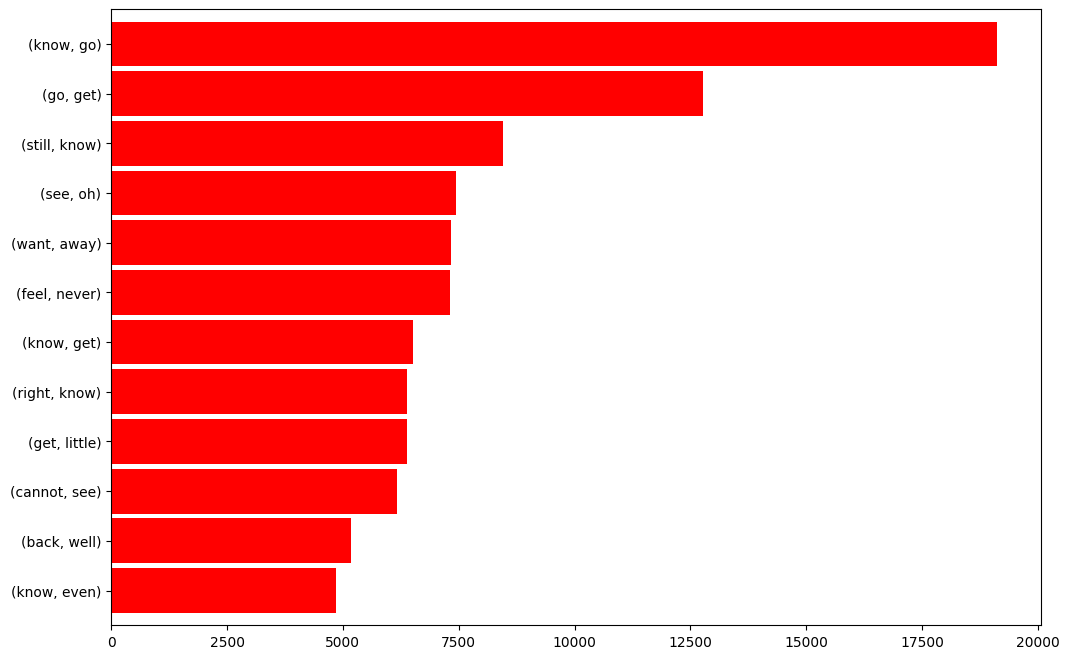

In [100]:
bigrams_series.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))

Text(0.5, 0, '# of Occurances')

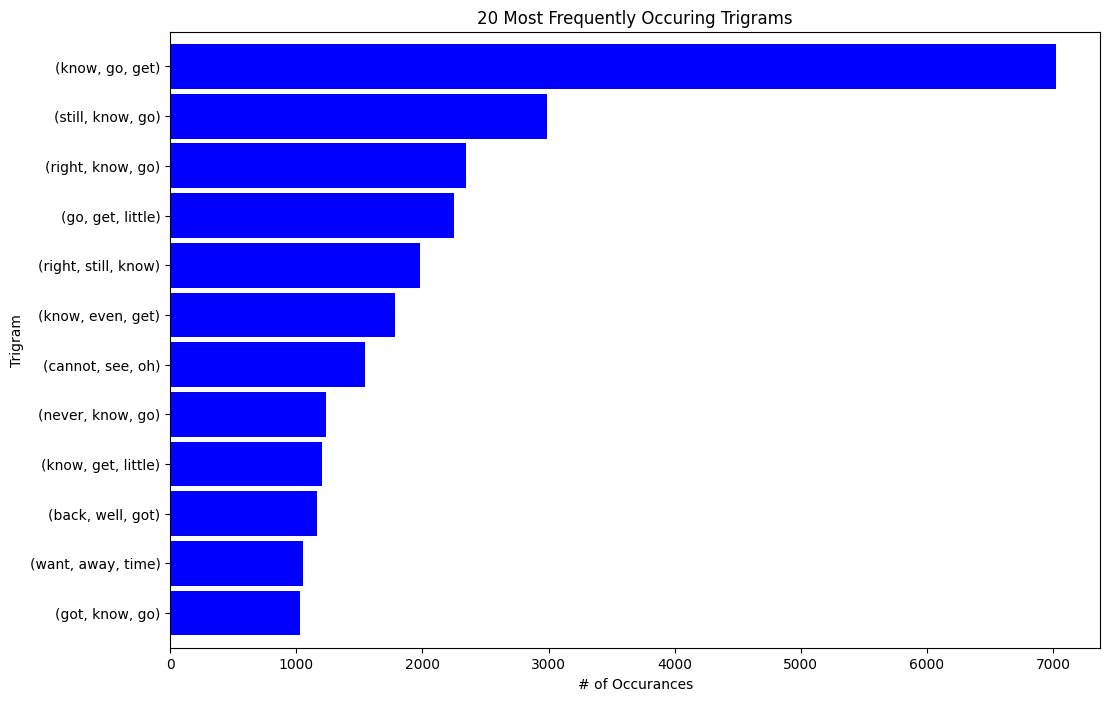

In [99]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [102]:
df['trigram']=(pd.Series(nltk.ngrams(words, 3)))

In [126]:
df.head()

,Unnamed: 0,artist,seq,song,label,word_count,seq_no_contract,description_str,body_text_tokenized,no_punc,stopwords_removed,body_text_lemmatized,word_count_applied,words,bigram,trigram
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,1.0,341,"[No,, no, I, are not, ever, trapped, out, the,...","No, no I are not ever trapped out the bando Bu...","[no, no, i, are, not, ever, trapped, out, the,...","[no, no, i, are, not, ever, trapped, out, the,...","[ever, trapped, bando, oh, lord, get, wrong, k...","[ever, trapped, bando, oh, lord, get, wrong, k...",179,"shit,everybody,got,loving,dream,heard,shout,pl...","(['shit, everybody)","(['shit, everybody, got)"
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,1.0,465,"[The, drinks, go, down, and, smoke, goes, up,,...","The drinks go down and smoke goes up, I feel m...","[the, drinks, go, down, and, smoke, goes, up, ...","[the, drinks, go, down, and, smoke, goes, up, ...","[drinks, go, smoke, goes, feel, got, let, go, ...","[drink, go, smoke, go, feel, got, let, go, car...",261,"eye,gone,like,circle,song,let,care,happier,hop...","(everybody, got)","(everybody, got, loving)"
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.0,279,"[She, do not, live, on, planet, Earth, no, mor...",She do not live on planet Earth no more She fo...,"[she, do, not, live, on, planet, earth, no, mo...","[she, do, not, live, on, planet, earth, no, mo...","[live, planet, earth, found, love, venus, word...","[live, planet, earth, found, love, venus, word...",117,"gone,man,caught,like,space,cheating,found,faul...","(got, loving)","(got, loving, dream)"
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,1.0,334,"[Trippin', off, that, Grigio,, mobbin',, light...","Trippin' off that Grigio, mobbin', lights low ...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, off, that, grigio, mobbin, lights, l...","[trippin, grigio, mobbin, lights, low, trippin...","[trippin, grigio, mobbin, light, low, trippin,...",179,"telling,suck,going,number,got,hell,picked,chea...","(loving, dream)","(loving, dream, heard)"
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.0,172,"[I, see, a, midnight, panther,, so, gallant, a...","I see a midnight panther, so gallant and so br...","[i, see, a, midnight, panther, so, gallant, an...","[i, see, a, midnight, panther, so, gallant, an...","[see, midnight, panther, gallant, brave, found...","[see, midnight, panther, gallant, brave, found...",78,"leave,found,minor,dirty,brave,see,never,get,ph...","(dream, heard)","(dream, heard, shout)"


In [117]:
X_train, X_test, y_train, y_test = train_test_split(df[["body_text_lemmatized","bigram","trigram"]],
                                                    df["label"],test_size=0.2,shuffle=True)

In [118]:
X_train.shape

(108791, 3)

In [119]:
y_train.shape

(108791,)

In [134]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_vect = CountVectorizer(ngram_range=(2,2),analyzer=clean_text) # It applies only bigram vectorizer
X_counts = ngram_vect.fit_transform(df['body_text_lemmatized'])
print(X_counts.shape)
print(ngram_vect.get_feature_names_out())

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


(135989, 132204)
[''
 '000100sensednewscentinnocentbentsensenewscentinnocentspentfeelgoodgoodsleepyriversleepyplacesleepyriversleepyplacemilksilversulk200fishwarmclearliquidfeelwetfeelkindmisguidedsleepyriversleepyplacesleepyriversleepyplacekindthingsleepyriversleepyriverthingsleepyriverthingsleepythingthingthingsleepyplacesleepy300sleepyriversleepyriverplaceplaceverbaltrashingverbaltrashingverbaltrashingverbaltrashingverbaltrashingmilksilversulknothingquiversleepyriverriverburnburnburnspacewordtumblesleepyriverwordtumblesleepyplace400sleepyriversleepyplacestoptwitchingalrighttwistedthinglaughingdisregarddisregardsleepyriverremindfallingwaterwetwantdaddy500rustyrustyveryverylustysleepylustylustylustylustywisheverythinglustylustybelievecolorbelievecolorbelievecomingungluedbelievefarawayfatherwaitingsleepyplacesleepyriver600sleepyplacesleepyriversleepyplacesleepycushywavesleepyplacesleepyriversleepyriversleepysleepyriversleepyriversleepyplace700sleepyplaceinnocentscentinnocentrepentinnoc